## Data Loading/Cleaning

Note: this file assumes that it is located in the same directory as the 534group2 folder downloaded from github. In order to work it must be moved to that directory.

In [39]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from shapely.geometry import Point
from scipy import stats

In [2]:
df_2000 = pd.read_csv('534group2/ACS data/2000_tractdata.csv', dtype={'GEOID11':str})
df_2010 = pd.read_csv('534group2/ACS data/2010_tractdata.csv', dtype={'GEOID11':str})
df_2018 = pd.read_csv('534group2/ACS data/2018_tractdata.csv', dtype={'GEOID11':str})

In [3]:
gdf_tracts_2010 = gpd.read_file('534group2/shapefiles/tl_2017_06_tract/')

In [4]:
goldtracts2010 = ['206020','206031','207103','206010','207102','206020',
                    '199000','185202','185310','199400','185100','183610',
                    '183620','183701','183810','183520','480600','480703',
                    '464000','463602','463700','461902','462302','462202',
                    '462201','462301','462700','463000','463102','462900']

controltracts2010 = ['203500','206032','197700','199700','207101',
                    '203500','185204','185203','199300',
                    '183220','183101','183820','183510','480704',
                    '480702','463601','463900','461700',
                    '463500','463601','462100','462400','463400',
                    '430600','463200','462800']

goldtracts2000 = ['206020','206030','207100','203500','207400',
                    '206010','207100','197700','199000','199400',
                    '199300','185202','185100','199300','183700','183810',
                    '183820','183610','183620','480704','480500','480703',
                    '480600','463900','464000','463700','463600','461900',
                    '462200','462300','462700','463102','463000','462900']

controltracts2000 = ['203300','204410','197600','203600','207300','199000',
                    '197600','197300','185320','199201','199202','185310',
                    '186200','201301','183101','183520','183510','183300',
                    '183220','480804','480400','201120','183102','463800',
                    '463500','461700','464100','462000','462100','462400',
                    '462600','463101','430600','462500']

In [5]:
#clean data, extract tracts from GEOIDs
df_2000['GEOID11'] = df_2000['GEOID11'].str.slice(-6) #pull tracts out of GEOIDs
df_2010['GEOID11'] = df_2010['GEOID11'].str.slice(-6) #pull tracts out of GEOIDs
df_2018['GEOID11'] = df_2018['GEOID11'].str.slice(-6) #pull tracts out of GEOIDs

df_2000 = df_2000.set_index('GEOID11') #set tracts as index
df_2010 = df_2010.set_index('GEOID11') #set tracts as index
df_2018 = df_2018.set_index('GEOID11') #set tracts as index

#clean med_hhinc column
df_2018['med_hhinc'] = df_2018['med_hhinc'].replace({'250,000+':'250000','-':'0'})
df_2018['med_hhinc'] = df_2018['med_hhinc'].astype(float)

df_2018['pct_white'] = df_2018['pct_white'].replace({'-':'0','#DIV/0!':'0'})
df_2018['pct_white'] = df_2018['pct_white'].astype(float)

df_2018['pct_poverty'] = df_2018['pct_poverty'].replace({'-':'0'})
df_2018['pct_poverty'] = df_2018['pct_poverty'].astype(float)

df_2018['uemp_rate'] = df_2018['uemp_rate'].replace({'-':'0'})
df_2018['uemp_rate'] = df_2018['uemp_rate'].astype(float)

In [6]:
#create new dataframes for station tracts
df_2018_stations = df_2018.loc[goldtracts2010]
df_2018_control = df_2018.loc[controltracts2010]

df_2010_stations = df_2010.loc[goldtracts2010]
df_2010_control = df_2010.loc[controltracts2010]

In [7]:
#creates dataframe called df_2018_all that includes tracts from the station and control groups
#df_2018_all has a column called 'exp' that =1 if tract is a station tract and 0 if tract is a control tract

df_2018_all = df_2018.loc[goldtracts2010 + controltracts2010]
df_2018_all['exp'] = [1 if i in goldtracts2010 else 0 for i,j in df_2018_all.iterrows()]

In [8]:
#CLean and merge gdf_tracts_2010 with 2018 ACS data in df_2018_all

gdf_tracts_2010['GEOID'] = gdf_tracts_2010['GEOID'].str.slice(-6) #pulls tracts out of GEOID column

#merge the datasets on census tract codes
gdf_2018_all = pd.merge(left=gdf_tracts_2010, right=df_2018_all, how='left', left_on='GEOID', right_on='GEOID11')

## Regressions

In [9]:
gdf_2018_all.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID_x', 'NAME', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'GEOID_y', '16+_emp_rate', '16+_uemp_rate', 'uemp_rate',
       'med_hhinc', 'pop', 'pct_white', 'pct_black', 'pct_asian', 'pct_other',
       'tol_hu', 'med_value', 'pct_noins', 'pct_poverty', 'city', 'metro',
       'med_rent', 'exp'],
      dtype='object')

In [48]:
#create variable for housing density
gdf_2018_all['housing_density'] = gdf_2018_all['tol_hu'] / gdf_2018_all['ALAND']

#create variable for population density
gdf_2018_all['pop_density'] = gdf_2018_all['pop'] / gdf_2018_all['ALAND']

#create variable for rent burden
gdf_2018_all['rent_burden'] = gdf_2018_all['med_hhinc'] / gdf_2018_all['med_rent'] 
gdf_2018_all['is_burdened'] = [1 if i > 0.3 else 0 for i in gdf_2018_all['rent_burden']]

In [63]:
#2018 regression on home values

response = 'rent_burden'
predictors = ['med_hhinc','pct_poverty','exp']

data = gdf_2018_all[[response] + predictors].dropna()

X = data[predictors]
Y = data[response]

model = sm.OLS(Y, sm.add_constant(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            rent_burden   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     24.50
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           4.42e-10
Time:                        12:29:47   Log-Likelihood:                -196.76
No. Observations:                  57   AIC:                             401.5
Df Residuals:                      53   BIC:                             409.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          39.6064      7.933      4.993      

### Difference in Means

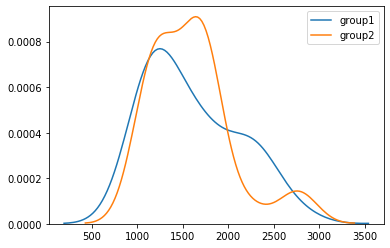

In [91]:
var = 'med_rent'

exp_tracts = gdf_2018_all[gdf_2018_all['exp'] == 1]
control_tracts = gdf_2018_all[gdf_2018_all['exp'] == 0]

group1 = exp_tracts[var]
group2 = control_tracts[var]

# # what are the distributions of these two groups?
ax = sns.kdeplot(group1, label='group1')
ax = sns.kdeplot(group2, label='group2', ax=ax)

In [87]:
print(int(group1.mean()))
print(int(group2.mean()))

1602
1590


In [88]:
group1.mean() - group2.mean()

11.774074074073951

In [89]:
# compute the t-stat and its p-value
t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
p_value = p_value / 2 #convert two-tailed p-value to one-tailed
print(t_statistic)
print(p_value) 

0.0936565187329529
0.4628611812868781
